<a href="https://colab.research.google.com/github/sungeun1028/Analysis-Project-/blob/main/7_%EB%94%A5%EB%9F%AC%EB%8B%9D_%EC%9D%B4%EC%A7%84%EB%B6%84%EB%A5%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# from google.colab import auth
# auth.authenticate_user()

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# 형태소분석기 설치
!apt-get update
!apt-get install g++ openjdk-8-jdk

!pip install JPype1
!pip install rhinoMorph

Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:5 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:6 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:8 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:9 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease [15.9 kB]
Hit:13 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:14 https://cloud.

In [3]:
# 경로 변경
%cd /content/gdrive/My\ Drive/pytest/

/content/gdrive/My Drive/pytest


In [4]:
!ls

alice.png  income.csv	    negative.txt  ratings_morphed.txt  ratings.txt
data	   income_test.csv  positive.txt  ratings_small.txt    wiki_test.txt


In [5]:
# 형태소 분석된 데이터 로딩
def read_data(filename, encoding='cp949'):               # 읽기 함수 정의
  with open(filename, 'r', encoding=encoding) as f:
    data = [line.split('\t') for line in f.read().splitlines()]
    data = data[1:]                                      # 첫 행은 헤더(id document label)일 수 있으므로 제외한다
  return data

def write_data(data, filename, encoding='cp949'):        # 쓰기 함수 정의
  with open(filename, 'w', encoding=encoding) as f:
    f.write(data)

data = read_data('ratings_morphed.txt', encoding='cp949')

print(type(data))
print(len(data))
print(len(data[0])) 
print(data[0])

<class 'list'>
492
3
['8132799', '디자인 배우다 학생 외국 디자이너 와 일군 전통 통하다 발전하다 문화 산업 부럽다 사실 우리나라 그 어렵다 시절 끝 열정 지키다 노라노 같다 전통 있다 같다 사람 꿈 꾸다 이루다 나가다 감사하다', '1']


In [6]:
# 무료 Colab에서 실행하기에는 데이터가 너무 많아 1/2로 줄인다
import random
import math
import numpy as np
random.shuffle(data)                            # data를 랜덤하게 섞음

part_num = math.floor(len(data) * 1/3)          # data의 1/3을 정수로 얻음
data = data[:part_num]                          # 앞에서부터 절반 크기의 데이터만 선택
print(len(data))

164


In [7]:
# 훈련데이터와 테스트데이터 분리
data_text = [line[1] for line in data]      		# 데이터 본문
data_senti = [line[2] for line in data]     		# 데이터 긍부정 부분

from sklearn.model_selection import train_test_split
train_data_text, test_data_text, train_data_senti, test_data_senti = train_test_split(data_text, data_senti, stratify=data_senti)

In [8]:
# Counter 클래스를 이용해 train과 test 데이터의 비율을 확인한다 
from collections import Counter
train_data_senti_freq = Counter(train_data_senti)
print('train_data_senti_freq:', train_data_senti_freq)

test_data_senti_freq = Counter(test_data_senti)
print('test_data_senti_freq:', test_data_senti_freq)

train_data_senti_freq: Counter({'1': 63, '0': 60})
test_data_senti_freq: Counter({'1': 21, '0': 20})


In [9]:
# 데이터의 단어 개수 통계
import numpy as np
text_len = [len(line.split(' ')) for line in train_data_text]  
print("최소길이: ", np.min(text_len))
print("최대길이: ", np.max(text_len))
print("평균길이: ", np.round(np.mean(text_len), 1))
print("중위수길이: ", np.median(text_len))
print("구간별 최대 길이: ", np.percentile(text_len, [0, 25, 50, 75, 90, 100]))

print()
print("최소길이 문장: ", train_data_text[np.argmin(text_len)])
print("최대길이 문장: ", train_data_text[np.argmax(text_len)])

최소길이:  1
최대길이:  37
평균길이:  9.3
중위수길이:  6.0
구간별 최대 길이:  [ 1.   4.   6.  12.  19.6 37. ]

최소길이 문장:  삐질삐질
최대길이 문장:  전윤수 미인도 살다 어린 여자 옷 벗기다 장면 명백하다 아동 학대 범죄 금 영화 아동 금 출현 가하다 일 책임 지지 못하다 어린아이 훗날 영화 출연 후회하다 어떻다 감독 영화 관계되다 어른 시간 되돌다 릴 수 있다


In [10]:
# Data Tokenizing
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np
import math

max_words = 10000                                         # 데이터셋에서 가장 빈도 높은 10,000 개의 단어만 사용한다
maxlen = 20                                               # 20개 이후의 단어는 버려 각 문장의 길이를 고정시킨다

tokenizer = Tokenizer(num_words=max_words)  	            # 상위빈도 10,000 개의 단어만을 추려내는 Tokenizer 객체 생성
tokenizer.fit_on_texts(train_data_text)                   # 단어 인덱스를 구축한다
word_index = tokenizer.word_index               	        # 단어 인덱스만 가져온다

In [11]:
# Tokenizing 결과 확인
print('전체에서 %s개의 고유한 토큰을 찾았습니다.' % len(word_index))
print('word_index type: ', type(word_index))
print('word_index: ', word_index)

전체에서 668개의 고유한 토큰을 찾았습니다.
word_index type:  <class 'dict'>
word_index:  {'영화': 1, '보다': 2, '없다': 3, '하다': 4, '너무': 5, '정말': 6, '좋다': 7, '사람': 8, '진짜': 9, '잘': 10, '다': 11, '최고': 12, '같다': 13, '수': 14, '말': 15, '내용': 16, '재미있다': 17, '스토리': 18, '만': 19, '아': 20, '왜': 21, '때': 22, '마음': 23, '연기': 24, '아깝다': 25, '이': 26, '만들다': 27, '좋아하다': 28, '대하다': 29, '나오다': 30, '재미': 31, '감동': 32, '답답하다': 33, '알다': 34, 'ㅠㅠ': 35, '어떻다': 36, '되다': 37, '안': 38, '자다': 39, '웃다': 40, '모르다': 41, '받다': 42, '돈': 43, '말다': 44, '주다': 45, '볼': 46, '드라마': 47, '당시': 48, '생각': 49, '있다': 50, '유치하다': 51, '모으다': 52, '역시': 53, '인생': 54, '못하다': 55, '평점': 56, 'ㅋ': 57, 'ㅋㅋㅋ': 58, '장면': 59, '생각하다': 60, '남자': 61, '지루하다': 62, '가다': 63, '못': 64, 'ㅇ': 65, '아직': 66, '그저': 67, '아이돌': 68, '배우': 69, '정도': 70, '들다': 71, '그렇다': 72, '쓰레기': 73, '그': 74, '주인공': 75, '연기자': 76, '여': 77, '놓다': 78, '더': 79, '헉': 80, '그런': 81, '청소년': 82, '어울리다': 83, '음악': 84, '많다': 85, '시간': 86, '비판': 87, '짜증': 88, '일': 89, '무슨': 90, '사랑하다': 91, '각본': 92, '눈물

In [12]:
# Data Sequencing
# 텍스트를 숫자로 변환하는 작업을 수행한다
# 상위 빈도 10,000(max_words)개의 단어만 추출하여 word_index의 숫자 리스트로 변환한다.
data = tokenizer.texts_to_sequences(train_data_text)		# Tokenizer 결과가 여기서 반영된다.

print('data 0:', data[0])
print('texts 0:', train_data_text[0])				            # train_data_text[0]의 본래 단어들

data 0: [170, 81, 171, 172, 15, 173]
texts 0: 어찌 그런 사명감 가지다 말 인가


In [13]:
# Data Padding
data = pad_sequences(data, maxlen=maxlen) 

print('data:', data)
print('data 0:', data[0])
print('data 0의 길이:', len(data[0]))

data: [[  0   0   0 ... 172  15 173]
 [  0   0   0 ...   6   7   1]
 [  0   0   0 ... 177 178  82]
 ...
 [ 26  47 654 ...   2  23 666]
 [  0   0   0 ...  46 169   1]
 [  0   0   0 ...   5  33 107]]
data 0: [  0   0   0   0   0   0   0   0   0   0   0   0   0   0 170  81 171 172
  15 173]
data 0의 길이: 20


In [14]:
print(type(train_data_text))
print(type(data))
print(data.shape)

<class 'list'>
<class 'numpy.ndarray'>
(123, 20)


In [15]:
# One-Hot-Encoding
def to_one_hot(sequences, dimension):
  results = np.zeros((len(sequences), dimension))
  for i, sequence in enumerate(sequences):
    results[i, sequence] = 1.
  return results


data = to_one_hot(data, dimension=max_words) 
labels = np.asarray(train_data_senti).astype('float32')   

In [16]:
# One-Hot-Encoding 결과 확인
print('data:', data)
print(len(data[0]))					       # dimension=10000으로 했으므로 각 행은 10,000개를 가지고 있다
print('data [0][0:100]:', data[0][0:100])

data: [[1. 0. 0. ... 0. 0. 0.]
 [1. 1. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [1. 1. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]
10000
data [0][0:100]: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


In [17]:
print(type(train_data_text))
print(type(data))
print(data.shape)

print('데이터 텐서의 차원:', data.ndim)
print('레이블 텐서의 차원:', labels.ndim)

print('데이터 텐서의 크기:', data.shape)  		# (74084, 10000)
print('레이블 텐서의 크기:', labels.shape) 		# (74084,)

<class 'list'>
<class 'numpy.ndarray'>
(123, 10000)
데이터 텐서의 차원: 2
레이블 텐서의 차원: 1
데이터 텐서의 크기: (123, 10000)
레이블 텐서의 크기: (123,)


In [18]:
validation_ratio = 0.3                          # 30%는 검증데이터로 사용한다. 나머지는 훈련데이터
validation_len = math.floor(len(train_data_text) * validation_ratio)    	

x_train = data[validation_len:]                 # 훈련데이터의 70%는 훈련데이터
y_train = labels[validation_len:]               # 훈련데이터의 70%는 훈련데이터 Label
x_val = data[:validation_len]                   # 훈련데이터의 30%는 검증데이터
y_val = labels[:validation_len]                 # 훈련데이터의 30%는 검증데이터 Label

In [19]:
# 모델 정의하기
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()                                              # 모델을 새로 정의

model.add(Dense(64, activation='relu', input_shape=(max_words,)))	# 첫 번째 은닉층
model.add(Dense(32, activation='relu'))                           # 두 번째 은닉층
model.add(Dense(1, activation='sigmoid'))                 		    # 출력층

# 모델 요약 출력
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                640064    
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 642,177
Trainable params: 642,177
Non-trainable params: 0
_________________________________________________________________


In [20]:
# Compile & Train Model
# 모델 컴파일
# 가중치 업데이트 방법은 RMSprop을 사용하였다. 이동평균의 방법을 도입하여 조절해간다
# 신경망의 출력이 확률이므로 crossentropy를 사용하는 것이 최선이다
# crossentropy는 원본의 확률 분포와 예측의 확률 분포를 측정하여 조절해 간다
# 또한 이진 분류이므로 binary_crossentropy를 사용한다
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

# 모델 훈련
# 32개씩 미니 배치를 만들어 5번의 epoch로 훈련한다. 보통 32개에서 시작하여 512개까지 중에서 찾는다
# 훈련 데이터로 훈련하고, 검증 데이터로 검증한다 
# 반환값의 history는 훈련하는 동안 발생한 모든 정보를 담고 있는 딕셔너리이다
history = model.fit(x_train, y_train, epochs=5, batch_size=32, validation_data=(x_val, y_val))
history_dict = history.history

Epoch 1/5
3/3 [==============================] - 1s 124ms/step - loss: 0.6947 - acc: 0.4713 - val_loss: 0.6930 - val_acc: 0.4167
Epoch 2/5
3/3 [==============================] - 0s 35ms/step - loss: 0.6640 - acc: 0.9885 - val_loss: 0.6930 - val_acc: 0.4444
Epoch 3/5
3/3 [==============================] - 0s 24ms/step - loss: 0.6361 - acc: 0.9885 - val_loss: 0.6912 - val_acc: 0.5000
Epoch 4/5
3/3 [==============================] - 0s 27ms/step - loss: 0.6033 - acc: 0.9885 - val_loss: 0.6903 - val_acc: 0.5278
Epoch 5/5
3/3 [==============================] - 0s 47ms/step - loss: 0.5673 - acc: 0.9885 - val_loss: 0.6899 - val_acc: 0.5000


In [21]:
# 경로 변경
%cd /content/gdrive/My Drive/pytest/

/content/gdrive/My Drive/pytest


In [22]:
# Save Model
# multidimensional numpy arrays를 저장할 수 있는 h5 file(HDF) 포맷으로 저장한다
model.save('text_binary_model.h5')


# 훈련데이터에서 사용된 상위빈도 10,000개의 단어로 된 Tokenizer 저장
# 새로 입력되는 문장에서도 같은 단어가 추출되게 한다
import pickle
with open('text_binary_tokenizer.pickle', 'wb') as handle:
  pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [23]:
# Accuracy & Loss 확인
# history 딕셔너리 안에 있는 정확도와 손실값을 가져와 본다

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

print('Train accuracy of each epoch:', np.round(acc, 3))
print('Validation accuracy of each epoch:', np.round(val_acc, 3))

Train accuracy of each epoch: [0.471 0.989 0.989 0.989 0.989]
Validation accuracy of each epoch: [0.417 0.444 0.5   0.528 0.5  ]


range(1, 6)


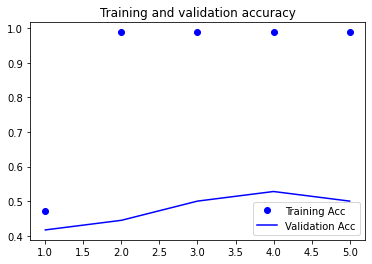

In [24]:
# Plotting Accuracy
import matplotlib.pyplot as plt

# 훈련데이터의 정확도에 비해 검증데이터의 정확도는 낮게 나타난다
# epoch가 높아지면 모델은 훈련데이터에 매우 민감해져 오히려 새로운 데이터를 잘 못 맞춘다
epochs = range(1, len(acc) +1)
print(epochs)

plt.plot(epochs, acc, 'bo', label='Training Acc')
plt.plot(epochs, val_acc, 'b', label='Validation Acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.show()

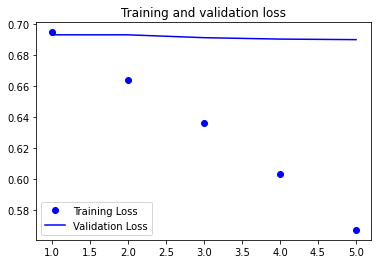

In [25]:
# Plotting Loss
plt.figure()    # 새로운 그림을 그린다

# 훈련데이터의 손실값은 낮아지나, 검증데이터의 손실값은 높아진다
# 손실값은 오류값을 말한다. 예측과 정답의 차이를 거리 계산으로 구한 값이다
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [26]:
# Load Model
import os
from keras.models import load_model

filepath = '/content/gdrive/My Drive/pytest/'
os.chdir(filepath)
print("Current Directory:", os.getcwd())

loaded_model = load_model('text_binary_model.h5')
print("model loaded:", loaded_model)

with open('text_binary_tokenizer.pickle', 'rb') as handle:
  loaded_tokenizer = pickle.load(handle)

Current Directory: /content/gdrive/My Drive/pytest
model loaded: <keras.engine.sequential.Sequential object at 0x7f84c3f708d0>


In [27]:
# 테스트데이터 재확인
print(test_data_text)
print(test_data_senti)

['방법 컨텐츠 모두 와 닿다 연출 각본 결국 감독 문제', '잔잔하다 재미 좋다', '흐흐흐 망하다 망하다', '영상미 보다 재미 있다 대사 거의 없다 심심하다 영화', '재미없다 억지', '아름답다 영화 두다 두다 간직하다 영화 소중한 사람 함께 보다', '아 진짜 너무 오다 글 못 보다 정도', '남자 라 그렇다 겁나다 긴장감 있다 흥미진진하다 ㄷㄷ 그렇다 워낙 격투 씬 좋아하다 ㅋㅋㅋ 그냥 생각 없다 집 스마트 티비 보다 재미있다 보다 무슨 영화 모르다 암살 나오다 이정재 걍 보다 ㅋㅋ 하여튼 너무 재미있다', '저 정말 너무 애정하다 드리다 이야기 정말 그 어떤 멜로 드라마 보다 아름답다 잊다 수 없다 정말 최영 장군 이민호 이민 호 나오다 드라마 최고 생각하다', '누다 잇다 감독 영화 정말 재미있다 진짜 보통 전쟁 영화 감독 특유 연출력 돋다 보이다 감동 원작 그렇다 스토리 굉장히 탄탄하다 강추', '정 극 도무지 어울리다 조니뎁 혁신 클래식하다 촬영기 법 거울 통하다 다중 인격 연출 킬링타임 적절하다 추가 조니뎁 정 극 하다 말다', '완전 감동 다시다 감동', '각본 인터넷 찌라시 수준 연기 허 접다 배우다 얼굴 부담', '로빈 윌리암스 주연 영화 들다 다 좋아하다 정말 최악', '잼 잼 잼 잼', '제하다', '말 필요 없다 감독 배우 존경하다', '배우다 들다 참 좋다 연기 송중 기다 나오다 억지로 꾸역꾸역 포기하다 결말 상하다', '전개 일단 원작 비하다 생략 많다 권투 씬 졸리다 잠 오다', '친구 우정 매우 감동', '나치 입장 보다 영화 갑자기 연속 나오다 무슨', '싣다 영화 보다 모르다', '진짜 재미없다 보다 말다 하다 본 다 멍청하다', '탱고 음악 감동 밀려오다', '영상 존재하다 죽기 전 꼭 한번 보다 아름답다 슬프다 제니퍼 코넬리 눈부시다 아역 시절 로버트 드니로 마지막 웃다 장면 정말 가슴속 영원히 기억되다 최고 명작', '일본 영화 참 많이 보다 끝 못 보다 영화 이것다 처음 유일하다', '쓰다 레 기', '실화 더욱

In [28]:
# Data Sequencing
# 문자열을 word_index의 숫자 리스트로 변환
data = loaded_tokenizer.texts_to_sequences(test_data_text)

# padding으로 문자열의 길이를 고정시킨다
data = pad_sequences(data, maxlen=maxlen) 

# test 데이터를 원-핫 인코딩한다
x_test = to_one_hot(data, dimension=max_words)

# test_data_senti를 list에서 넘파이 배열로 변환
y_test = np.asarray(test_data_senti).astype('float32') 

In [29]:
# Test Data Evaluation
test_eval = loaded_model.evaluate(x_test, y_test)	  # 모델에 분류할 데이터와 그 정답을 같이 넣어준다
print('prediction model loss & acc:', test_eval)		# 모델이 분류한 결과와 입력된 정답을 비교한 결과

2/2 [==============================] - 0s 7ms/step - loss: 0.6717 - acc: 0.6098
prediction model loss & acc: [0.6716979146003723, 0.6097561120986938]


In [30]:
# 1개 데이터 예측
# 형태소분석을 포함하여 이제까지의 과정을 모두 진행해주어야 한다

text = ["재미있게 잘 봤습니다"]      # 데이터를 list 타입으로 만든다

import rhinoMorph
rn = rhinoMorph.startRhino()                         		

# 리스트 컴프리헨션으로 실질형태소만을 리스트로 가져온다
text=[rhinoMorph.onlyMorph_list(rn, sentence, pos=['NNG', 'NNP', 'NP', 'VV', 'VA', 'XR', 'IC', 'MM', 'MAG', 'MAJ'], eomi=False) for sentence in text]
print('형태소 분석 결과:', text)

data = loaded_tokenizer.texts_to_sequences(text)
data = pad_sequences(data, maxlen=maxlen)
x_test = to_one_hot(data, dimension=max_words)

prediction = loaded_model.predict(x_test)
print("Result:", prediction)					       # [[0.9472448]]. 1(긍정)일 확률이 95%

filepath:  /usr/local/lib/python3.7/dist-packages
classpath:  /usr/local/lib/python3.7/dist-packages/rhinoMorph/lib/rhino.jar
RHINO started!
형태소 분석 결과: [['재미있', '잘', '보']]
Result: [[0.53751]]
